# <font  color = "#0093AF"> A Quick Start

We will go through the various objects in this chapter in detail, but in this section we will just do a quick summary. Note that we will usually use consistent variable names for each type of object. These names are given in () after each class name 

- ExpSys (ex): Describes basic details of the experiment and spin-system. This includes magnetic field, nuclei in the system, spinning frequency if included, temperature, powder average, spin-field and spin-spin interactions, etc.
- Liouvillian (L): Contains the Liouvillian, which has coherent terms originating from interactions in ExpSys, but also can contain relaxation terms, and potentially includes exchange processes that modulate interactions, defined by including two or more ExpSys in exchange.
- Hamiltonian (H): Contains the Hamiltonian, although the user can bypass the Hamiltonian and generate the Liouvillian directly (Hamiltonians are contained within the Liouvillian).
- Sequence (seq): Generated from a Liouvillian, and allows the user to define time-dependent, multi-channel pulse sequences. Sequences can be used directly with the density matrix, or can be used to generator propagators.
- Propagator (U): Propagates the density matrix forward in time. Propagators can be generated from a sequence, in which case they will include rf-pulses in the sequence, or from the Liouvillian directly, in which case no rf irradiation is included. Identity propagators and $\delta$-pulses are available from the Liouvillian. Propagators may be multiplied together or by the density matrix. They may also be raised to integer powers (in solid-state NMR, they must then be exactly one rotor period).
- Rho (rho): Rho is the density matrix, which defines the state of the spin-system. In SLEEPY, rho also contains the detection operator, so that simply calling rho (`rho()`) will perform a detection operation for the current state of the density matrix. Rho records all detection operations and stores the results in `rho.I`, which is a 2D matrix (the first dimension runs over possible multiple detection operators, the second dimension runs over all detection calls). A special function, `rho.DetProp` takes a sequence or propagator and executes multiple detection and propagation steps (this function usually operates in the eigenbasis, making this calculation much faster than simply looping over propagation and detection operations). The Rho 'plot' function will plot either time-domain or Fourier transformed spectra (`FT=True`).

Note that SLEEPY is intended to be *interactive*, so each of these objects will provide a description of itself if its variable name is typed at the command line, or included in a "print" call. Furthermore, except for ExpSys, each object has a "plot" function, that gives a graphical representation of the object or a plot of data in the object.

## Setup

In [18]:
import os
os.chdir('../../../')
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt

## Example: $^{13}$C $R_{1\rho}$

In [4]:
# 600 MHz, H-C system, MAS at 60 kHz, 49 powder angles (JPC59), 50 steps per rotor period
ex0=sl.ExpSys(v0H=600,Nucs=['13C','1H'],vr=60000,pwdavg=2,n_gamma=50)
ex0.set_inter('dipole',i0=0,i1=1,delta=44000) #One-bond H-C dipole coupling
ex1=ex0.copy() #Copy the above setup
_=ex1.set_inter('dipole',i0=0,i1=1,delta=44000,euler=[0,30*np.pi/180,0]) #Reorient the dipole coupling by 30 degrees

<Axes: >

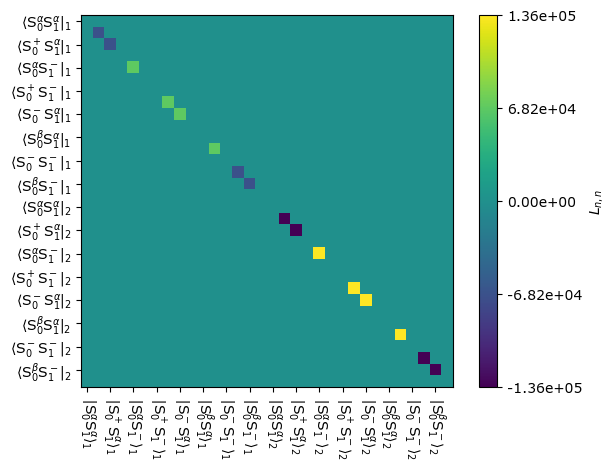

In [16]:
# Liouvillian, with ex0 and ex1 included
L=sl.Liouvillian(ex0,ex1)
# Add symmetric exchange matrix to Liouvillian, with 5 microsecond tc
tc=5e-6
L.kex=1/(2*tc)*np.array([[-1,1],[1,-1]])

[<Axes: ylabel='$v_1$ / kHz'>,
 <Axes: xlabel='t / $\\mu$s', ylabel='$v_1$ / kHz'>]

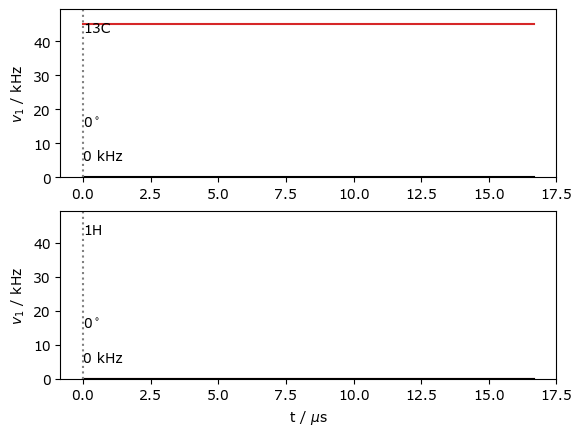

In [7]:
#Generate a pulse-sequence from L
seq=L.Sequence()
# Add a 45 kHz pulse on the 13C channel (x), for one rotor period (this is the default, so could be omitted)
seq.add_channel('13C',t=[0,L.taur],v1=45000,phase=0)
# Plot the pulse-sequence
seq.plot()

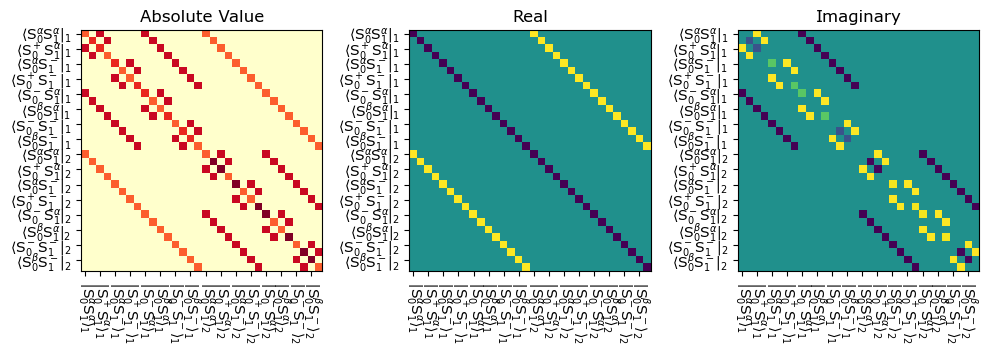

In [24]:
# Graphical representation of L, combined with the applied field
# Abs, and also separated into real and imaginary components
fig,ax=plt.subplots(1,3)
L.plot(seq=seq,mode='abs',ax=ax[0],colorbar=False)
ax[0].set_title('Absolute Value')
L.plot(seq=seq,mode='re',ax=ax[1],colorbar=False)
ax[1].set_title('Real')
L.plot(seq=seq,mode='im',ax=ax[2],colorbar=False)
ax[2].set_title('Imaginary')
fig.set_size_inches([10,5])
fig.tight_layout()

In [34]:
# Create a density matrix, with initial state and detection matrix
# We'll start with '13Cz', so we can demonstrate how to use a delta-pulse to bring the magnetization to x
rho=sl.Rho(rho0='13Cz',detect='13Cx')

In [35]:
#13C pi/2 delta pulse along y
Upi2y=L.Udelta('13C',phi=np.pi/2,phase=np.pi/2)
# Apply the pi/2 pulse to rho
Upi2y*rho

Density Matrix/Detection Operator
rho0: 13Cz
detect[0]: 13Cx
Current time is 0.000 microseconds
0 time points have been recorded


In [36]:
# Apply the sequence to rho 1000 times, detecting at each step
# Here we use the DetProp function, which will perform this operation in the eigenbasis
rho.DetProp(seq,n=1000)

State-space reduction: 32->16


Density Matrix/Detection Operator
rho0: 13Cz
detect[0]: 13Cx
Current time is 16666.667 microseconds
1000 time points have been recorded


<Axes: xlabel='t / ms', ylabel='<$^{13}C_x$>'>

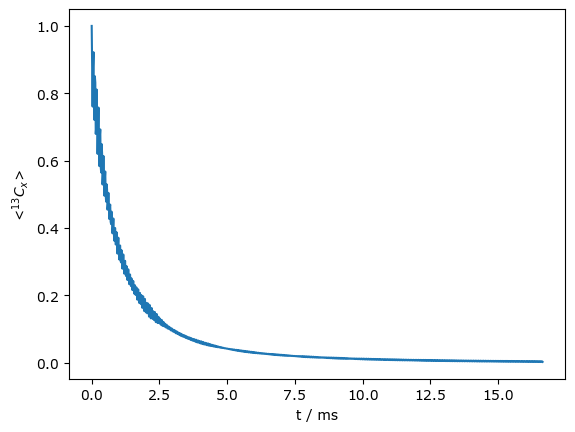

In [37]:
# Plot the resulting time-dependent magnetization
rho.plot()